In [1]:
%load_ext autoreload
%autoreload 2

import sys
import itertools
import utils
import numpy as np
import cvxpy as cvx
import matplotlib.pyplot as plt

from matplotlib import cm

In [2]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['figure.dpi'] = 80

# Room setup

We define a domain $\Omega$ and obstacles $\mathscr{O}$.

$\newcommand{\NN}{\mathbb N}$
$\newcommand{\RR}{\mathbb R}$
$\newcommand{\dif}{\mathrm{d}}$
$\renewcommand{\epsilon}{\varepsilon}$
$\renewcommand{\phi}{\varphi}$
$$
\DeclareMathOperator{\supp}{supp}
\DeclareMathOperator*{\argmin}{argmin}
\DeclareMathOperator*{\argmax}{argmax}
$$
$\DeclareMathOperator{\supp}{supp}$
$\DeclareMathOperator{\KL}{KL}$
$\DeclareMathOperator{\prox}{prox}$

In [3]:
nx = 81
xar = np.linspace(0, 1, nx)
xg, yg = np.meshgrid(xar, xar)

extent = [0,1,0,1]

In [4]:
def plot_domain(mask, cax=None, extent=extent):
    """Plot the domain in black & white"""
    if cax is None:
        cax = plt.gca()
    cax.imshow(mask, origin='lower', cmap=cm.Greys, extent=extent,
               interpolation='none', zorder=5)

def plot_measure(a, cax=None, cmap=cm.Greys, extent=extent, **kwargs):
    if cax is None:
        cax = plt.gca()
    kwargs['cmap'] = cmap
    cax.imshow(a, origin='lower', 
               extent=extent, **kwargs)

In [5]:
def send_zero_transparent(a):
    res = np.zeros((nx,nx,4))
    res[..., 3] = a/a.max()
    return res

In [6]:
# Obstacle domain
mask = ((0.64 <= yg) & (yg <= 0.7)) & (xg <= 0.75)
mask[:] = mask | ((0.4 <= yg) & (yg <= 0.44)) & (xg <= 0.75)
mask[:] = mask | ((xg <= 0.001) | (xg >= 0.999))

obstacle_idx = np.argwhere(mask)

domain_img = np.zeros((nx, nx, 4))
domain_img[mask, 3] = 1.

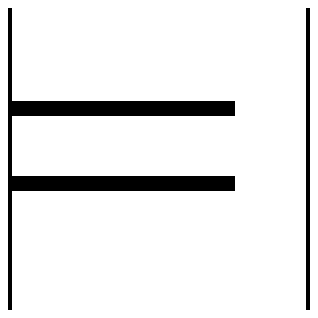

In [7]:
fig = plt.figure()
plot_domain(domain_img)
plt.axis('off');

# Standard two-measure transport problem

## Initial and target distributions

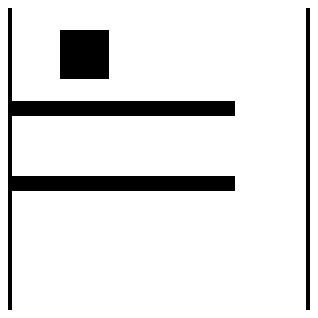

In [8]:
rho_0 = (np.abs(xg - 0.25) <= 0.08) & (np.abs(yg - 0.85) <= 0.08)
rho_0 = rho_0.astype(np.float64)
rho_0 /= rho_0.sum()  # normalize the density

fig, ax = plt.subplots()

plot_measure(rho_0, ax)
plot_domain(domain_img, ax)
plt.axis('off');


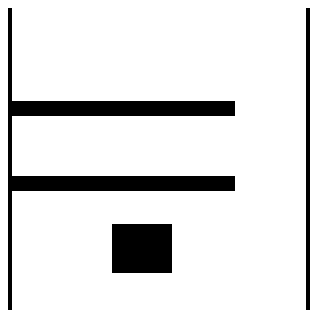

In [9]:
rho_tgt = (np.abs(xg - 0.45) <= 0.1) & (np.abs(yg - 0.2) <= 0.08)
rho_tgt = rho_tgt.astype(np.float64)
rho_tgt /= rho_tgt.sum()  # normalize the density

fig, ax = plt.subplots()

plot_measure(rho_tgt, ax);
plot_domain(domain_img, ax)
plt.axis('off');

## Problem setup

We first seek to minimize the following transport problem
$$
    \min_{\gamma} H(\gamma | R)
$$
subject to $\gamma_0 = P^0_\#\gamma = \rho_0$ and $\gamma_1 =P^1_\#\gamma = \rho_1$ (which is equivalent to penalizing with a function $G(\mu) = \imath_{\rho_1}(\mu)$).

The application $H$ is the Kullback-Leibler divergence
$$
    H(\alpha|\beta) = \sum_x\left(
    \alpha(x) \log\left(\frac{\alpha(x)}{\beta(x)}\right)
    - \alpha(x) + \beta(x)
    \right) =
    \left\langle \alpha, \log\frac\alpha\beta \right\rangle - \langle \alpha,\mathbf 1\rangle
    + \langle\beta, \mathbf 1\rangle
$$

$R = R_{0,1}$ is the marginal of the 2D Wiener measure at times $t=0,1$, which is given by the Gaussian kernel
$$
    R(x,y) = G_1(y_1-x_1)G_1(y_2-x_2)
$$
where $G_t \sim \mathcal N(0,t)$.

In [10]:
from scipy.stats import norm
from scipy.spatial import distance

Convolution with respect to this kernel can be computed fast.

In [11]:
# x-direction kernel
cost_mat1 = distance.cdist(xar[:, None],
                           xar[:, None])  # distance between 1st-coordinates
# Gaussian PDF applied element-wise
K1 = norm.pdf(cost_mat1)

K1.shape

(81, 81)

In [12]:
K_kernel = lambda x: np.dot(K1 @ x, K1)

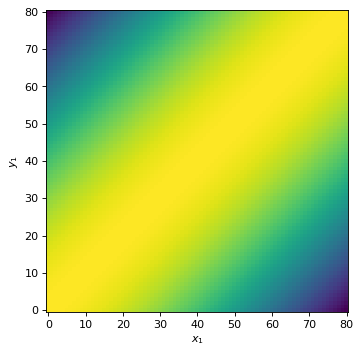

In [13]:
plt.imshow(K1, origin='lower', interpolation='none')
plt.xlabel("$x_1$")
plt.ylabel("$y_1$");

The appropriate iterative Bregman algorithm consists in KL-projecting the kernel $R$ alternatively on the constraints.

This leads to the usual Sinkhorn iterations.

In [14]:
n_iter = 100

u0 = np.ones_like(rho_0)
u1 = np.ones_like(rho_tgt)

for n in range(n_iter):
    u0[:] = rho_0 / K_kernel(u1)
    u1[:] = rho_tgt / K_kernel(u0)

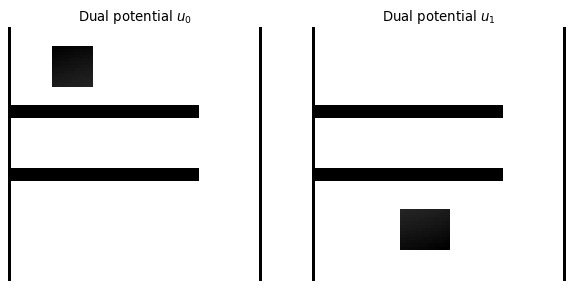

In [15]:
plt.figure(frameon=False, figsize=(9,7))
ax = plt.subplot(121)
plot_measure(u0, ax)
plot_domain(domain_img, ax)
ax.set_title("Dual potential $u_0$")
plt.axis('off');

ax = plt.subplot(122)
plot_measure(u1, ax)
plot_domain(domain_img, ax)
ax.set_title("Dual potential $u_1$")
plt.axis('off');

# Transport with fuzzy target

We start to move towards a mean-field control problem.

Given a marginal $\rho_0$, we now solve
$$
    \inf_\gamma H(\gamma | R) + G(P^1_\#\gamma)
$$
subject to $P^0_\#\gamma = \rho_0$, and with the penalty functional
$$
    G(\mu) = \int_\Omega \Psi(x)\,\dif\mu(x)
$$

We can use the potential $\Psi$ to target a desired distribution, as a relaxation of the former hard-constraint problem.

## Defining a potential $\Psi$

The first case is
$$
    \Psi(x) = d(x, \mathscr{A})^2
$$
where $\mathscr{A}$ is a subset of $\Omega$.

In [16]:
grid_arr_ = np.dstack([xg, yg])

grid_arr_flat = grid_arr_.reshape(nx*nx, 2)

In [17]:
target_mask = ((grid_arr_flat[:,0] <= 0.4) &
               (grid_arr_flat[:,0] >= 0.05) &
               (grid_arr_flat[:,1] <= 0.03))


target_points = grid_arr_flat[target_mask]

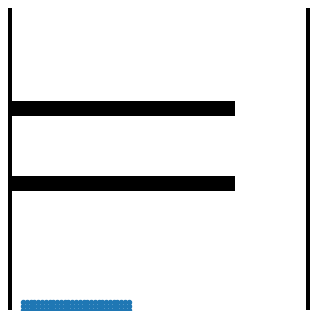

In [18]:
plot_domain(domain_img)
ylim = plt.ylim()
plt.scatter(*target_points.T, s=15)
plt.ylim(*ylim)
plt.axis('off');

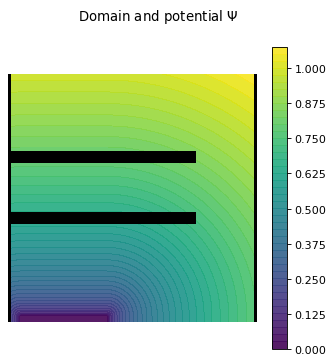

In [20]:
all_dists_ = distance.cdist(grid_arr_flat, target_points)

dist_to_target = all_dists_.min(axis=1)
dist_to_target = dist_to_target.reshape(nx, nx)

psi_potential_ = dist_to_target ** 0.5

fig, ax = plt.subplots(frameon=False)
cf_ = ax.contourf(xg, yg, psi_potential_, levels=50, alpha=.9)
fig.colorbar(cf_)

plot_domain(domain_img, ax)
plt.axis('off');

plt.suptitle("Domain and potential $\\Psi$");

The discretized problem
$$
\begin{aligned}
    &\inf_\gamma H(\gamma|R) + \langle \Psi, \gamma^T\mathbf 1\rangle\\
    \text{s.t.}\ & \rho_0 = \gamma\mathbf 1
\end{aligned}
$$
can be shown to have a closed-form solution. Indeed, solving this convex problem leads to the following optimality condition:
\\[
\begin{aligned}
    \gamma^* &= R \odot (e^{u_0^*} \otimes e^{-\Psi}) \\
    e^{u_0^*} &= \frac{\rho_0}{Re^{-\Psi}}
\end{aligned}
\\]

Then, we get the final distribution $\rho_1$ as
$$
    \rho_1 = (\gamma^*)^T\mathbf 1
    = e^{-\Psi} \odot R e^{u_0^*}
$$

In [58]:
u0 = rho_0 / K_kernel(np.exp(-psi_potential_))
rho_final = np.exp(-psi_potential_) * (K_kernel(u0))

print("Total mass:", rho_final.sum())

# Check the Lagrange multiplier condition:
print("Mass is zero on mask:", np.allclose(rho_final * mask, 0))

Total mass: 1.0
Mass is zero on mask: False


So we see the total mass is still $1$, but that there is mass contained on the obstacles (which was previsible, we did nothing to prevent that).

In [33]:
print("Amount on mass on mask:", np.sum(rho_final * mask))

Amount on mass on mask: 0.09916391928513471


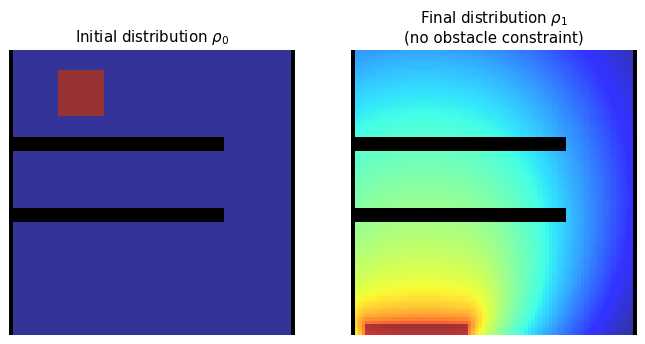

In [34]:
fig = plt.figure(figsize=(9, 8), dpi=90)

alpha_m = 0.8
plt.subplot(121)
plot_measure(rho_0, cmap=cm.jet, alpha=alpha_m)
plot_domain(domain_img)
plt.title("Initial distribution $\\rho_0$")
plt.axis('off');

plt.subplot(122)
plot_measure(rho_final, cmap=cm.jet, alpha=alpha_m,
             interpolation='none')
plot_domain(domain_img)
plt.title("Final distribution $\\rho_1$\n(no obstacle constraint)")
plt.axis('off');

In [35]:
fig.savefig("images/fuzzy_transport_noobstacle.png", bbox_inches='tight')

## Adding the domain's obstacles

We can decompose the final distribution criterion $G$ as the sum of the potential $\Psi$ and a hard constraint:
$$
    G = G_1 + G_2\ \text{with}\
$$
with
$$
    \begin{aligned}
    G_1(\mu) &= \int_\Omega\Psi(x) \, \dif\mu(x) \\
    G_2(\mu) &= \int_\Omega V(x)\, \dif\mu(x)
    \end{aligned}
$$

Where $V$ is the indicatrix of the obstacles
$$
    V(x) = \begin{cases}
    \infty &\text{ if } x\in\mathscr O \\
    0 &\text{ otherwise}
    \end{cases}
$$

We can see that $G_2$ is the convex indicatrix of the set of measures $\mu$ with support in $\Omega\backslash \mathscr O$.

The discretized problem is then
$$
\begin{aligned}
    &\inf_{\gamma,\rho_1} H(\gamma|R) + \langle \Psi, \rho_1 \rangle \\
    \text{s.t.}\ & \gamma \mathbf{1} = \rho_0  \\
    & \gamma^T\mathbf 1 = \rho_1   \\
    & \rho_1(x) \leq 0 \quad \forall x \in \mathscr O 
\end{aligned}
$$


Its dual is equivalent to
$$
    \sup_{u_0, \xi}~ q(u_0,\xi) = \left\langle R, \mathbf{1} - e^{u_0\oplus (-\Psi-\xi)}\right\rangle + \langle u_0,\rho_0\rangle
$$
where the Lagrange multiplier $\xi \geq 0$ is supported in $\mathscr O$ (we set $\xi(y) = 0$ for $y \in \Omega\backslash\mathscr O$).

The optimum satisfies
$$
    e^{u_0^*} = \frac{\rho_0}{R e^{-(\Psi + \xi^*)}}
$$
and upper-bounding with respect to $\xi$ yields an upper bound as $\xi(y) \to +\infty$, thus
$$
    e^{u_0^*} = \frac{\rho_0}{R\hat\psi}
$$
where $\hat\psi(y) = \mathbf 1_{y\not\in\mathscr O}e^{-\Psi(y)}$.

Then, the final distribution is given by
$$
    \rho_1 = \gamma^T\mathbf 1 = \hat\psi \odot Re^{u_0^*}
$$

In [59]:
## RECALL: mask is the indicatrix of obstacles
psi_hat = (1-mask) * np.exp(-psi_potential_)
u0 = rho_0 / K_kernel(psi_hat)  # potential u0

rho_final = K_kernel(u0) * psi_hat

print("Total mass:", rho_final.sum())

# Check the Lagrange multiplier condition:
print("Mass is zero on mask:", np.allclose(rho_final * mask, 0))

Total mass: 0.9999999999999999
Mass is zero on mask: True


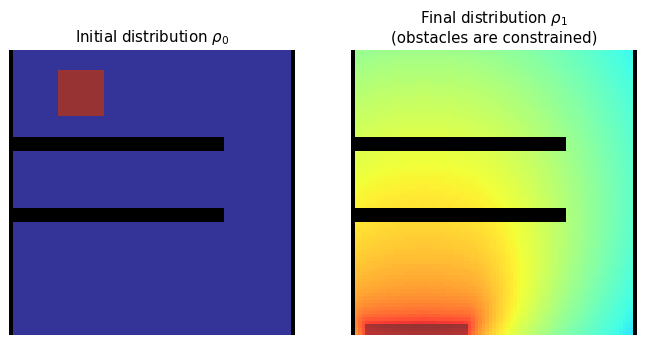

In [30]:
fig = plt.figure(figsize=(9, 8), dpi=90)

alpha_m = 0.8

plt.subplot(121)
plot_measure(rho_0, cmap=cm.jet, alpha=alpha_m)
plot_domain(domain_img)
plt.title("Initial distribution $\\rho_0$")
plt.axis('off')

plt.subplot(122)
plot_measure(rho_final, cmap=cm.jet, alpha=alpha_m,
             interpolation='none')
plot_domain(domain_img)
plt.title("Final distribution $\\rho_1$\n(obstacles are constrained)")
plt.axis('off');

In [31]:
fig.savefig("images/fuzzy_transport_withobstacle.png", bbox_inches='tight')

## With a viscosity parameter

We can reduce the "viscosity" of the transport by modifying the Wiener measure and its variance. We denote $R_\epsilon$ the Wiener measure associated with Wiener processes of variance $\epsilon > 0$.

In [163]:
epsilon = 0.01
K1_eps = norm.pdf(cost_mat1, scale=epsilon ** .5)
K_eps_ker = lambda x: np.dot(K1_eps @ x, K1_eps)

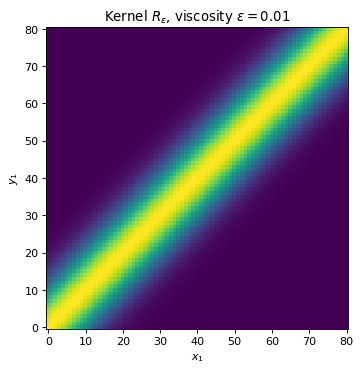

In [164]:
plt.imshow(K1_eps, origin='lower', interpolation='none')
plt.title("Kernel $R_\\epsilon$, viscosity $\\epsilon=%.2f$" % epsilon)
plt.xlabel("$x_1$")
plt.ylabel("$y_1$");

The obstacle-constrained transport problem from before is solved with the new kernel as:
$$
    e^{u_0^*} = \frac{\rho_0}{R_\epsilon\hat\psi}
$$

In [165]:
## RECALL: mask is the indicatrix of obstacles
psi_hat = (1-mask) * np.exp(-psi_potential_)
u0_eps = rho_0 / K_eps_ker(psi_hat)  # potential u0

rho_final = K_eps_ker(u0) * psi_hat

print("Total mass:", rho_final.sum())

# Check the Lagrange multiplier condition:
print("Mass is zero on mask:", np.allclose(rho_final * mask, 0))

Total mass: 5.68761846690868
Mass is zero on mask: True


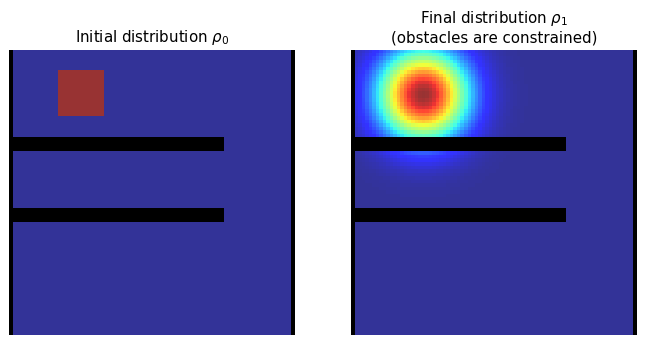

In [166]:
fig = plt.figure(figsize=(9, 8), dpi=90)

alpha_m = 0.8

plt.subplot(121)
plot_measure(rho_0, cmap=cm.jet, alpha=alpha_m)
plot_domain(domain_img)
plt.title("Initial distribution $\\rho_0$")
plt.axis('off')

plt.subplot(122)
plot_measure(rho_final, cmap=cm.jet, alpha=alpha_m,
             interpolation='none')
plot_domain(domain_img)
plt.title("Final distribution $\\rho_1$\n(obstacles are constrained)")
plt.axis('off');